<a href="https://colab.research.google.com/github/tamara-kostova/IIS/blob/master/recommender_lastfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages and import libraries

In [20]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [16]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [14]:
!pip install networkx

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import torch
from torch import optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# Load the dataset

In [22]:
artists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/artists.dat', sep='\t', header=None, names=['id', 'name', 'url', 'pictureURL'])
tags_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/tags.dat', sep='\t', header=None, names=['tagID', 'tagValue'], encoding='latin-1')
user_artists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_artists.dat', sep='\t', header=None, names=['userID', 'artistID', 'weight'])
user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t', header=None, names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])
user_friends_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_friends.dat', sep='\t', header=None, names=['userID', 'friendID'])

<ipython-input-22-1869bb55c873>:4: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t', header=None, names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])


## Explore the dataset

In [23]:
artists_df.head()

id               name                                         url  \
0  id               name                                         url   
1   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
2   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
3   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
4   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   

                                          pictureURL  
0                                         pictureURL  
1    http://userserve-ak.last.fm/serve/252/10808.jpg  
2  http://userserve-ak.last.fm/serve/252/3052066.jpg  
3  http://userserve-ak.last.fm/serve/252/40222717...  
4  http://userserve-ak.last.fm/serve/252/54697835...

In [24]:
artists_df.describe()

id   name    url  pictureURL
count   17633  17633  17633       17189
unique  17633  17633  17633       17189
top        id   name    url  pictureURL
freq        1      1      1           1

In [25]:
user_artists_df.head()

userID  artistID  weight
0  userID  artistID  weight
1       2        51   13883
2       2        52   11690
3       2        53   11351
4       2        54   10300

In [26]:
user_artists_df.describe()

userID artistID weight
count   92835    92835  92835
unique   1893    17633   5437
top      1030       89      1
freq       50      611    636

In [27]:
user_taggedartists_df.head()

userID  artistID  tagID  day  month  year
0  userID  artistID  tagID  day  month  year
1       2        52     13    1      4  2009
2       2        52     15    1      4  2009
3       2        52     18    1      4  2009
4       2        52     21    1      4  2009

In [28]:
user_taggedartists_df.describe()

userID artistID   tagID     day   month    year
count   186480   186480  186480  186480  186480  186480
unique    1894    18589   11170       8      25      19
top       1672      289      73       1       8    2010
freq      2609      701    5325  128480   12704   37474

### Distribution of Users' Listening Counts

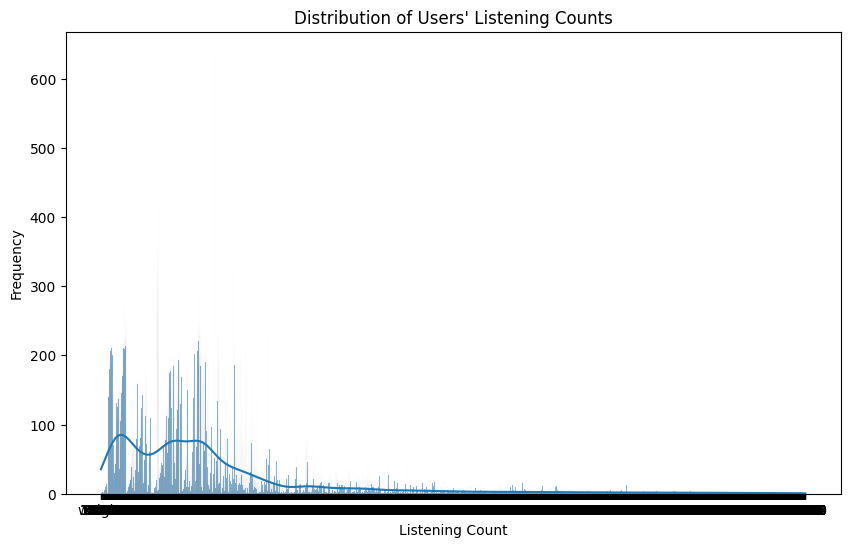

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(user_artists_df['weight'], bins=10, kde=True)
plt.title("Distribution of Users' Listening Counts")
plt.xlabel('Listening Count')
plt.ylabel('Frequency')
plt.show()

### Filter interactions with numeric weights

In [38]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [39]:
user_artists_df = user_artists_df[user_artists_df['weight'].apply(is_numeric)]

In [40]:
user_artists_df['weight'] = user_artists_df['weight'].astype(float)

### Top 10 Most Listened Artists

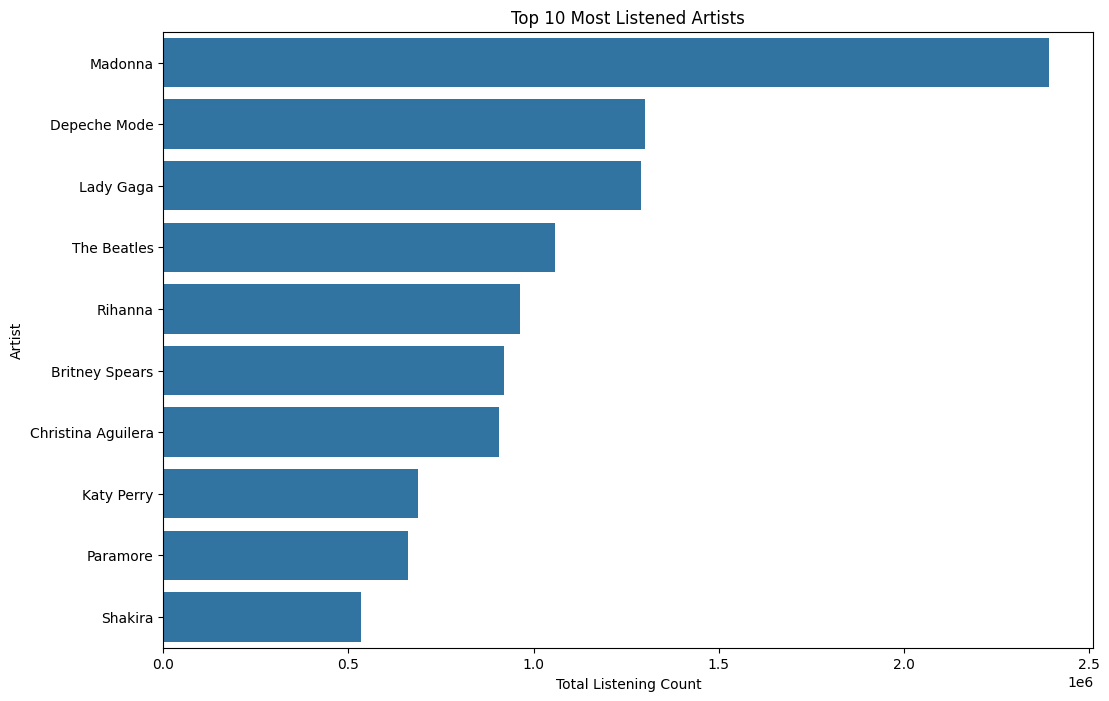

In [41]:
top_artists = user_artists_df.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_names = artists_df[artists_df['id'].isin(top_artists.index)]['name']

plt.figure(figsize=(12, 8))
sns.barplot(x=top_artists.values, y=top_artists_names)
plt.title('Top 10 Most Listened Artists')
plt.xlabel('Total Listening Count')
plt.ylabel('Artist')
plt.show()

### Number of Fans Artists Have

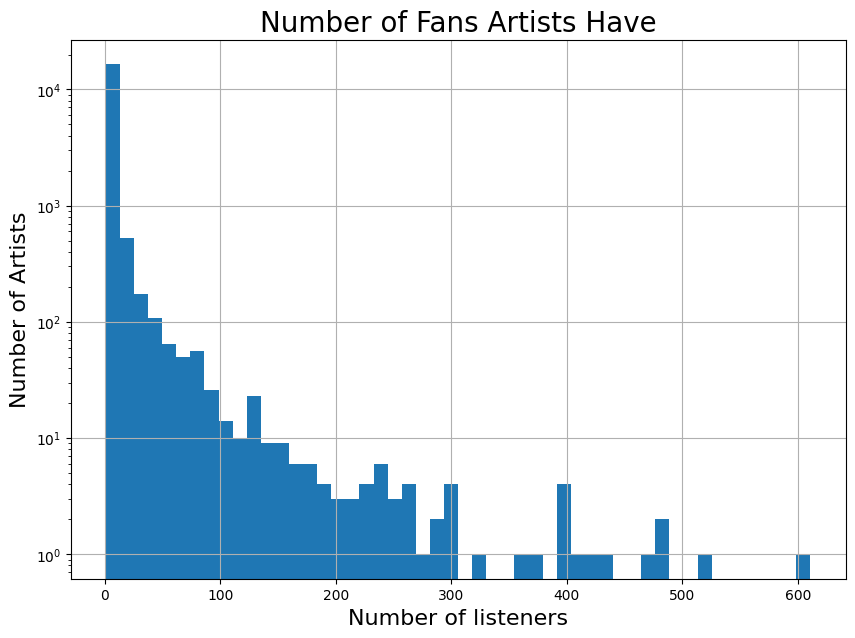

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))
user_artists_df.groupby("artistID")["userID"].nunique().hist(bins=50, ax=ax)
plt.title("Number of Fans Artists Have", fontsize=20)
plt.xlabel("Number of listeners", fontsize=16)
plt.ylabel("Number of Artists", fontsize=16)
plt.yscale("log")
plt.show()

### User Friendships Network

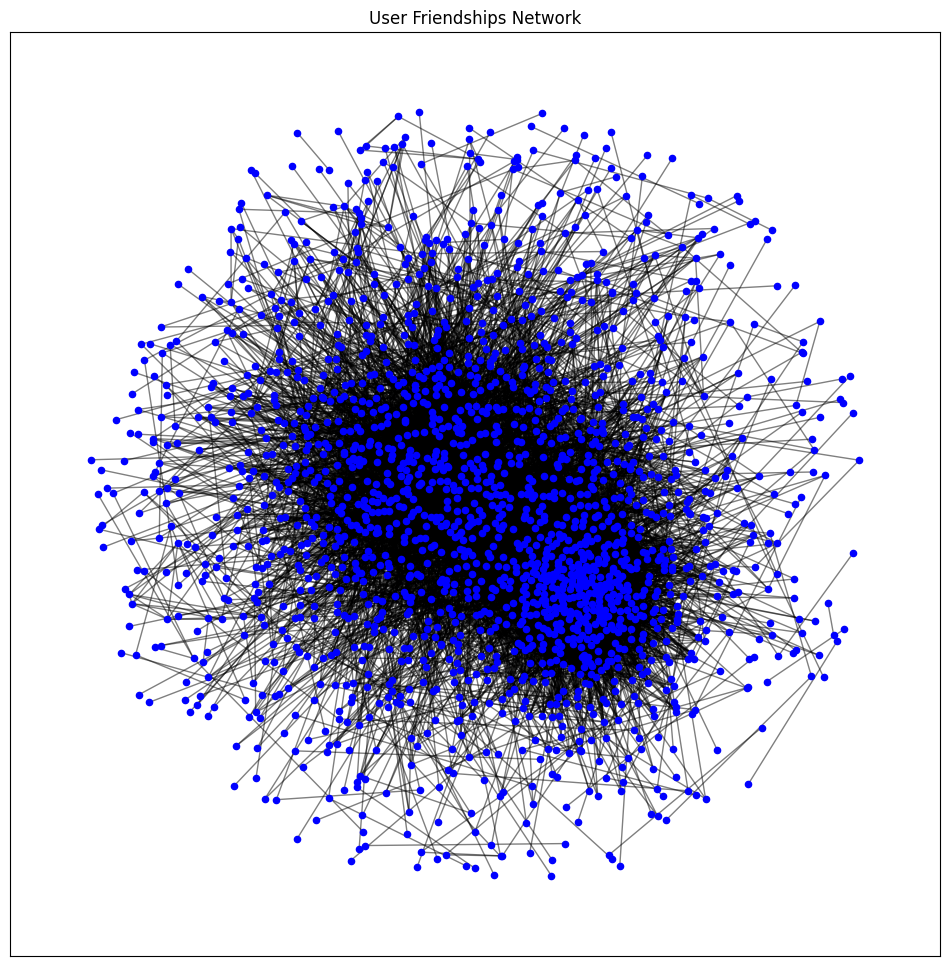

In [43]:
G = nx.from_pandas_edgelist(user_friends_df, 'userID', 'friendID')

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.2)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('User Friendships Network')
plt.show()

### Number of Friends Users Have

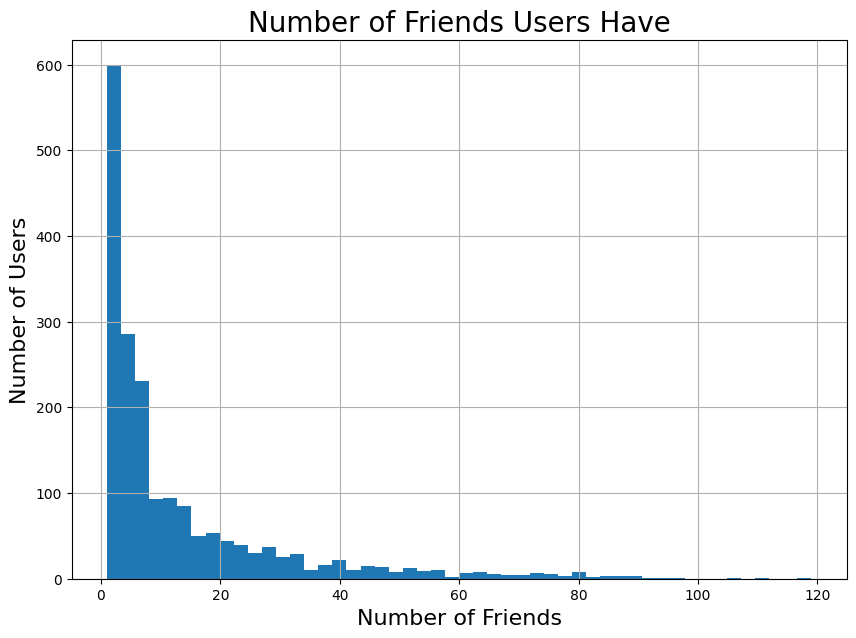

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))
user_friends_df.groupby("userID")["friendID"].nunique().hist(bins=50, ax=ax)
plt.title("Number of Friends Users Have", fontsize=20)
plt.ylabel("Number of Users", fontsize=16)
plt.xlabel("Number of Friends", fontsize=16)
plt.show()

### Heatmap of User-Artist Interactions

In [48]:
interaction_matrix

artistID   1  10  100  1000  10000  10001  10002  10003  10004  10005  ...  \
userID                                                                 ...   
10       NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
100      NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1001     NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1002     NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1003     NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
...       ..  ..  ...   ...    ...    ...    ...    ...    ...    ...  ...   
995      NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
996      NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
997      NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
998      NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
999      NaN NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   

artistID  9990  9991  9992  9993  9994  9995  9996  9997  9998  9999  
userID                                                                
10         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
100        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1001       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1002       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1003       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
995        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
996        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
997        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
998        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
999        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1892 rows x 17632 columns]

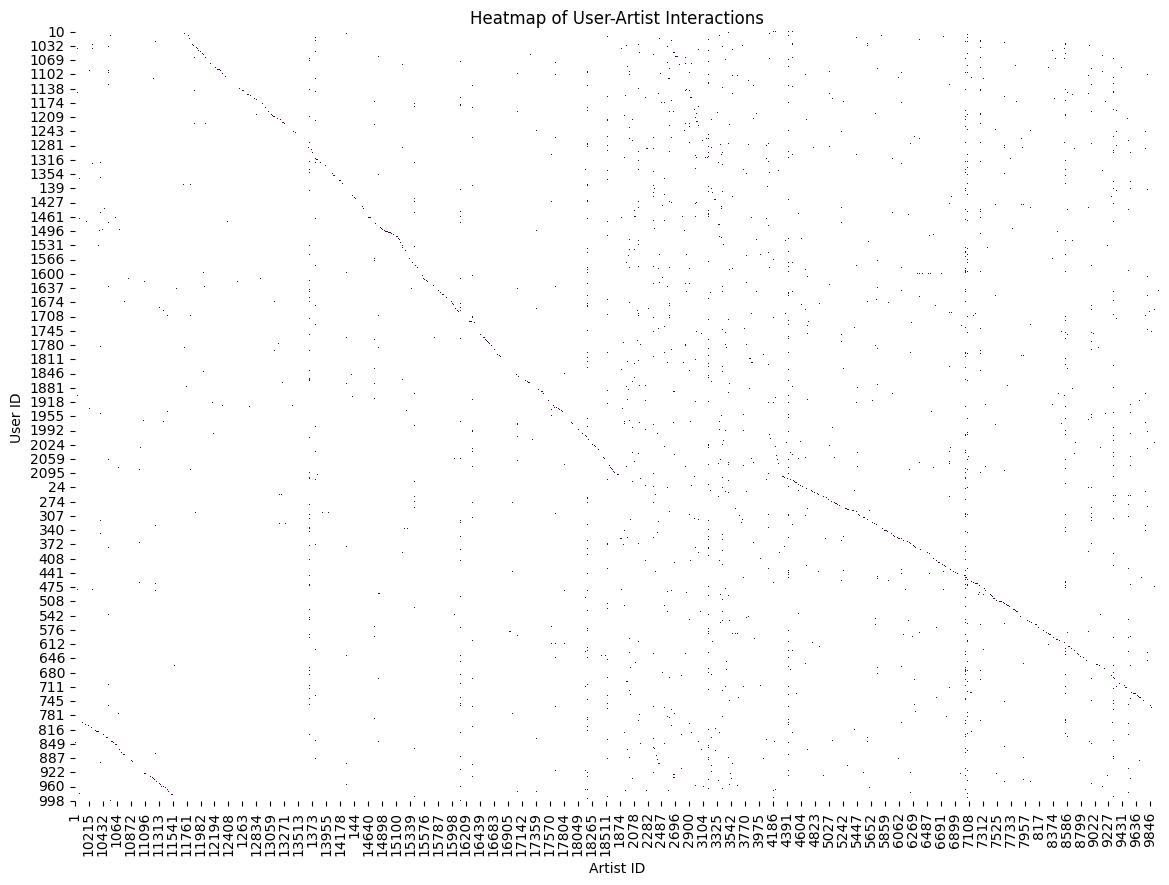

In [47]:
interaction_matrix = user_artists_df.pivot(index='userID', columns='artistID', values='weight')

plt.figure(figsize=(14, 10))
sns.heatmap(interaction_matrix, cmap='viridis', cbar=False)
plt.title('Heatmap of User-Artist Interactions')
plt.xlabel('Artist ID')
plt.ylabel('User ID')
plt.show()

# Additional exploration

In [49]:
artists = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/artists.dat', sep='\t', usecols=['id','name'])
user_artists = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_artists.dat', sep='\t')

In [50]:
merged = pd.merge(artists,
                user_artists,
                how='inner',
                left_on='id',
                right_on='artistID')

merged = merged.rename(columns={"weight":"plays"})

merged.head()

id             name  userID  artistID  plays
0   1     MALICE MIZER      34         1    212
1   1     MALICE MIZER     274         1    483
2   1     MALICE MIZER     785         1     76
3   2  Diary of Dreams     135         2   1021
4   2  Diary of Dreams     257         2    152

In [51]:
artist_rank = (merged.groupby(['name']).agg({'userID':'count','plays':'sum'}).
    rename(columns={"userID":'totalUniqueUsers',"plays":"totalArtistPlays"}).
              sort_values(['totalArtistPlays'],ascending=False))
artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']

user_rank = (merged.groupby(['userID']).agg({'name':'count','plays':'sum'}).
    rename(columns={"name":'totalUniqueArtists',"plays":"totalUserPlays"}).
            sort_values(['totalUserPlays'],ascending=False))

In [52]:
artist_rank.head()

totalUniqueUsers  totalArtistPlays  avgUserPlays
name                                                                
Britney Spears                   522           2393140   4584.559387
Depeche Mode                     282           1301308   4614.567376
Lady Gaga                        611           1291387   2113.563011
Christina Aguilera               407           1058405   2600.503686
Paramore                         399            963449   2414.659148

In [53]:
user_rank.head()

totalUniqueArtists  totalUserPlays
userID                                    
757                     50          480039
2000                    50          468409
1418                    50          416349
1642                    50          388251
1094                    50          379125

### Join all tables

In [56]:
merged = merged.join(artist_rank,on='name', how='inner')
final = merged.join(user_rank,on='userID', how='inner').sort_values(['plays'],ascending=False)

# confirm no duplicated rows
assert final[final.duplicated(['userID','name'])].empty

In [57]:
final.head()

id          name  userID  artistID   plays  totalUniqueUsers  \
2800    72  Depeche Mode    1642        72  352698               282   
35843  792        Thalía    2071       792  324663                26   
27302  511            U2    1094       511  320725               185   
8152   203          Blur    1905       203  257978               114   
26670  498      Paramore    1664       498  227829               399   

       totalArtistPlays  avgUserPlays  totalUniqueArtists  totalUserPlays  
2800            1301308   4614.567376                  50          388251  
35843            350035  13462.884615                  50          338400  
27302            493024   2664.994595                  50          379125  
8152             318221   2791.412281                  50          276295  
26670            963449   2414.659148                  50          251560

# Graph

In [58]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [59]:
G = nx.Graph()

In [60]:
users = set(user_artists_df['userID'])
artists = set(user_artists_df['artistID'])

Remove non-numeric edges

In [61]:
def clean_edge_weights(G):
    for u, v, data in G.edges(data=True):
        if 'weight' in data:
            try:
                data['weight'] = float(data['weight'])
            except ValueError:
                G.remove_edge(u, v)
                print(f"Removed edge ({u}, {v}) with invalid weight: {data['weight']}")

## Add nodes

### users

In [121]:
G.add_nodes_from(users, bipartite=0, type='user')

In [75]:
user_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'user']
print(f"Number of user nodes: {len(user_nodes)}")

Number of user nodes: 1892


### artists

In [63]:
G.add_nodes_from(artists, bipartite=1, type='artist')

In [74]:
# Count artist nodes again
artist_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'artist']
print(f"Number of artist nodes: {len(artist_nodes)}")


Number of artist nodes: 15752


## Add edges

In [67]:
for _, row in user_artists_df.iterrows():
    G.add_edge(row['userID'], row['artistID'], weight=float(row['weight']), relation='listens')

In [71]:
# Verify user IDs in the graph
users_in_graph = set(G.nodes())
user_ids_from_df = set(user_artists_df['userID'].astype(str))

missing_users = user_ids_from_df - users_in_graph
print(f"Missing user IDs: {missing_users}")
print(f"Number of missing user IDs: {len(missing_users)}")


Missing user IDs: set()
Number of missing user IDs: 0


# Visualization

In [73]:
clean_edge_weights(G)

In [79]:
pos = nx.spring_layout(G, seed=42, k=0.5)

In [76]:
# Separate users and artists
user_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'user']
artist_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'artist']

# Define node colors and shapes
node_colors = []
node_shapes = []
for node in G.nodes:
    if node in user_nodes:
        node_colors.append('lightblue')
        node_shapes.append('o')
    else:
        node_colors.append('lightgreen')
        node_shapes.append('s')

In [77]:
len(user_nodes)

1892

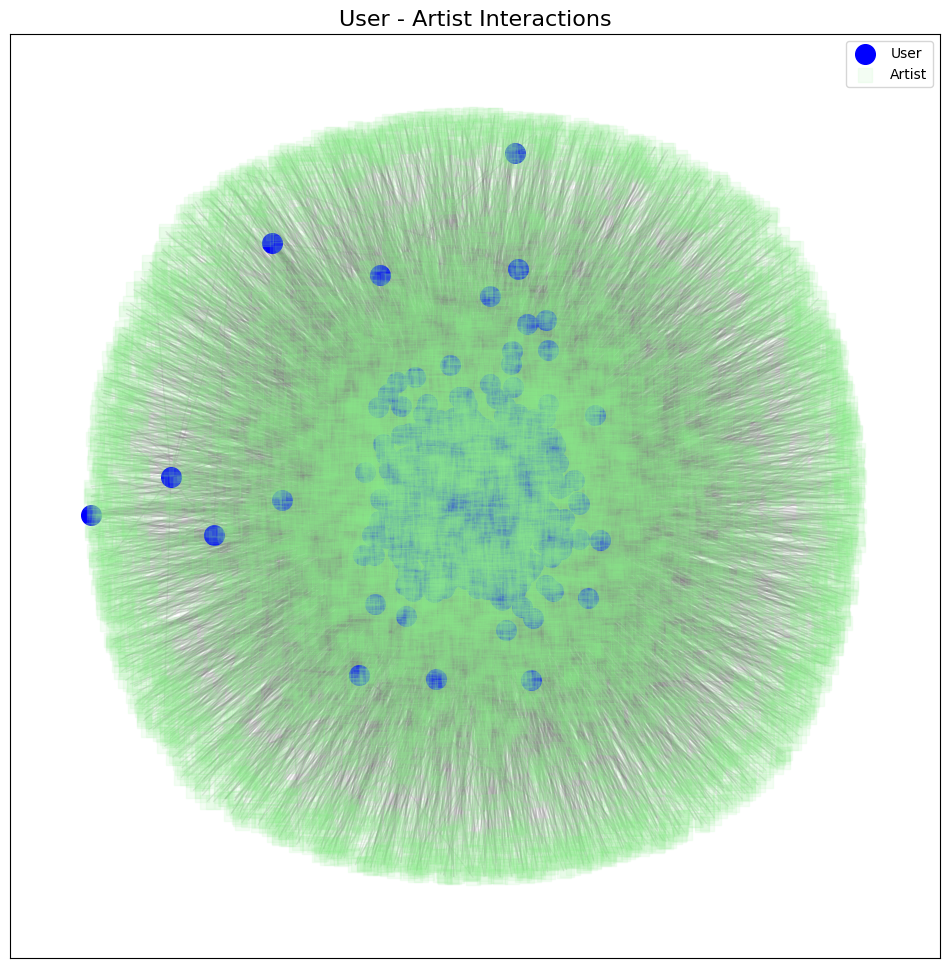

In [80]:
plt.figure(figsize=(12, 12))

# Draw users
nx.draw_networkx_nodes(
    G, pos,
    nodelist=user_nodes,
    node_color='blue',
    node_shape='o',
    node_size=200,
    label='User',
    alpha=1
)

# Draw artists
nx.draw_networkx_nodes(
    G, pos,
    nodelist=artist_nodes,
    node_color='lightgreen',
    node_shape='s',
    node_size=100,
    label='Artist',
    alpha = 0.1
)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2)

# Draw labels
# nx.draw_networkx_labels(G, pos, font_size=8,
#     font_color='black',  # Change label color
#     # font_weight='bold',  # Change label weight
#     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.title('User - Artist Interactions', fontsize=16)
plt.legend(['User', 'Artist'], loc='best')
plt.show()

In [117]:
default_node_attrs = {'type': 'unknown'}

# Check all nodes and add missing attributes with default values
for node in G.nodes():
    for attr in default_node_attrs:
        if attr not in G.nodes[node]:
            G.nodes[node][attr] = default_node_attrs[attr]

# Set attributes for users and artists
for i, user in enumerate(users):
    G.nodes[user]['type'] = 'user'
    print(f'user{i+1}')

for artist in artists:
    G.nodes[artist]['type'] = 'artist'

user1
user2
user3
user4
user5
user6
user7
user8
user9
user10
user11
user12
user13
user14
user15
user16
user17
user18
user19
user20
user21
user22
user23
user24
user25
user26
user27
user28
user29
user30
user31
user32
user33
user34
user35
user36
user37
user38
user39
user40
user41
user42
user43
user44
user45
user46
user47
user48
user49
user50
user51
user52
user53
user54
user55
user56
user57
user58
user59
user60
user61
user62
user63
user64
user65
user66
user67
user68
user69
user70
user71
user72
user73
user74
user75
user76
user77
user78
user79
user80
user81
user82
user83
user84
user85
user86
user87
user88
user89
user90
user91
user92
user93
user94
user95
user96
user97
user98
user99
user100
user101
user102
user103
user104
user105
user106
user107
user108
user109
user110
user111
user112
user113
user114
user115
user116
user117
user118
user119
user120
user121
user122
user123
user124
user125
user126
user127
user128
user129
user130
user131
user132
user133
user134
user135
user136
user137
user138
user

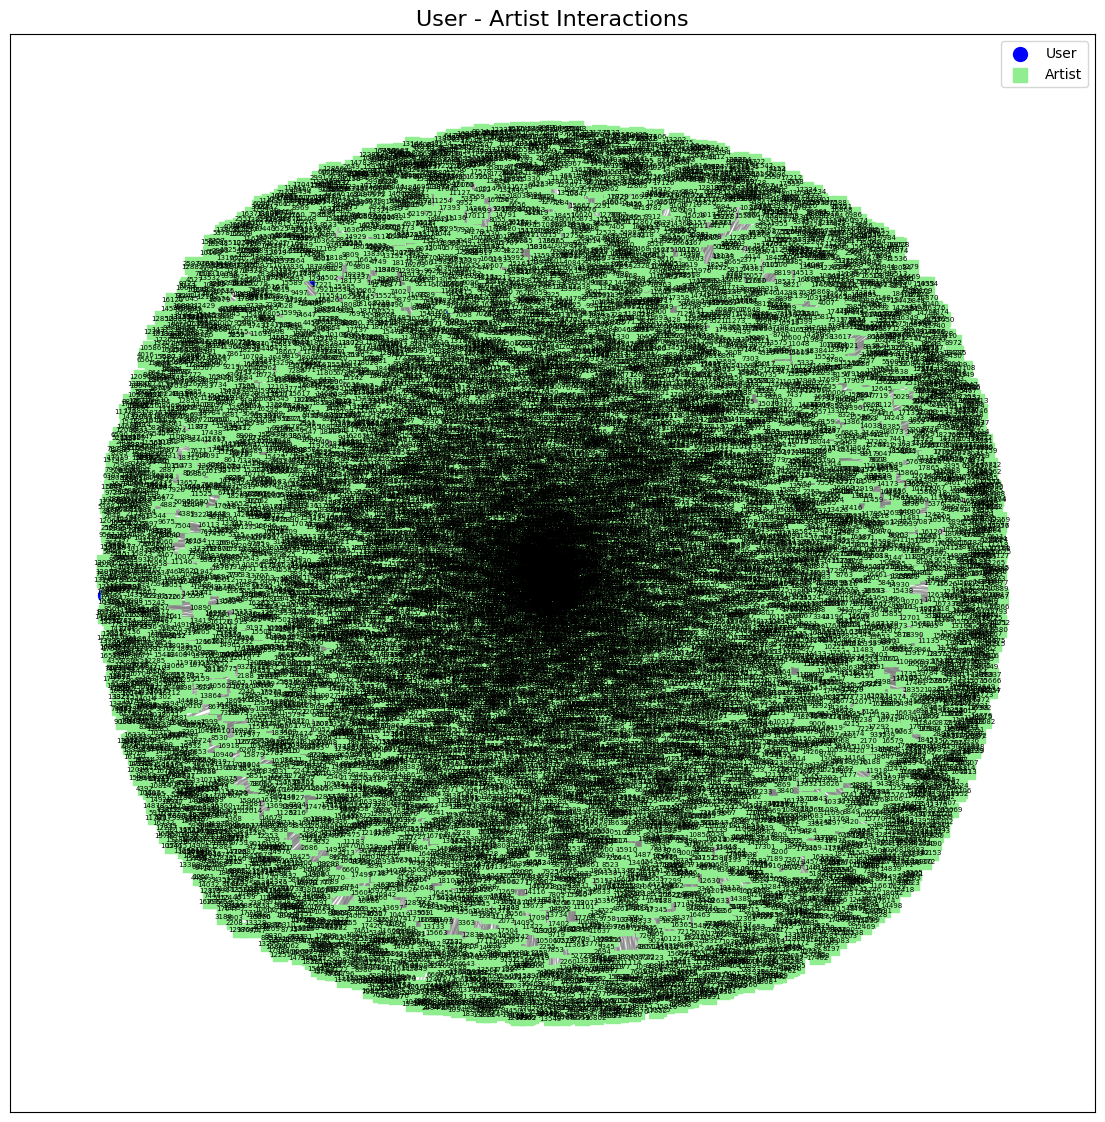

In [82]:
# Separate users and artists
user_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'user']
artist_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'artist']

# Define colors and shapes
node_colors = ['blue' if node in user_nodes else 'lightgreen' for node in G.nodes]
node_shapes = ['o' if node in user_nodes else 's' for node in G.nodes]

plt.figure(figsize=(14, 14))

# Draw nodes with different shapes and colors
for shape, color, nodes in zip(['o', 's'], ['blue', 'lightgreen'], [user_nodes, artist_nodes]):
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_color=color,
        node_shape=shape,
        node_size=100,
        label='User' if shape == 'o' else 'Artist'
    )

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=5)

plt.title('User - Artist Interactions', fontsize=16)
plt.legend(['User', 'Artist'], loc='best')
plt.show()


# GNN models

### Train and test functions

In [84]:
def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(pyg_data.x, pyg_data.edge_index)
    loss = criterion(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [85]:
def test(model):
    model.eval()
    out = model(pyg_data)
    pred = out.argmax(dim=1)
    correct = pred[pyg_data.val_mask] == labels[pyg_data.val_mask]
    accuracy = int(correct.sum()) / pyg_data.val_mask.sum()
    return accuracy

In [86]:
def get_recommendations(user_ids, model, pyg_data, top_k=5):
    model.eval()
    with torch.no_grad():
        # Compute embeddings
        out = model(pyg_data.x, pyg_data.edge_index)
        embeddings = out.numpy()

        # Get user and artist node indices
        user_indices = [node for node in G.nodes if G.nodes[node]['type'] == 'user']
        artist_indices = [node for node in G.nodes if G.nodes[node]['type'] == 'artist']
        user_ids = [int(uid) for uid in user_ids]
        artist_indices = [int(aid) for aid in artist_indices]

        # Check if indices are within the range of embeddings
        max_index = embeddings.shape[0] - 1
        user_ids = [uid for uid in user_ids if 0 <= uid <= max_index]
        artist_indices = [aid for aid in artist_indices if 0 <= aid <= max_index]

        # Create a dictionary to store recommendations
        recommendations = {}

        for user in user_ids:
            if user >= len(embeddings):
                continue
            user_embedding = embeddings[user]
            similarities = []

            for artist in artist_indices:
                if artist >= len(embeddings):
                    continue
                artist_embedding = embeddings[artist]
                sim = np.dot(user_embedding, artist_embedding) / (np.linalg.norm(user_embedding) * np.linalg.norm(artist_embedding))
                similarities.append((artist, sim))

            # Sort artists by similarity and get top K recommendations
            similarities.sort(key=lambda x: x[1], reverse=True)
            top_artists = [artist for artist, _ in similarities[:top_k]]
            recommendations[user] = top_artists

        return recommendations

## Prepare graph data for models

In [87]:
pyg_data = from_networkx(G)

In [88]:
pyg_data

Data(edge_index=[2, 184760], bipartite=[17644], type=[17644], weight=[184760], relation=[184760], num_nodes=17644)

In [89]:
# Create a mask for training/validation split
train_mask = torch.zeros(pyg_data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(pyg_data.num_nodes, dtype=torch.bool)

num_nodes = pyg_data.num_nodes
num_train = int(0.8 * num_nodes)
train_mask[:num_train] = True
val_mask[num_train:] = True

# Add masks to the data
pyg_data.train_mask = train_mask
pyg_data.val_mask = val_mask

In [90]:
# Dummy features
num_nodes = pyg_data.num_nodes
num_features = 1  # ne feature per node
pyg_data.x = torch.ones((num_nodes, num_features))

# Create labels based on 'type' attribute
node_types = [G.nodes[node]['type'] for node in G.nodes()]
labels = torch.zeros(num_nodes, dtype=torch.long)

# Map 'user' to 0 and 'artist' to 1
for i, node_type in enumerate(node_types):
    if node_type == 'user':
        labels[i] = 0
    elif node_type == 'artist':
        labels[i] = 1

# Attach labels to PyG Data object
pyg_data.y = labels

# Ensure correct size and dtype
print(labels)

tensor([1, 1, 1,  ..., 1, 1, 1])


## GCN Model

In [91]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [96]:
model_gcn = GCN()
optimizer = optim.Adam(model_gcn.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [93]:
model_gcn

GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 2)
)

In [97]:
for epoch in range(200):
    loss = train(model_gcn)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 0, Loss: 0.7572
Epoch 10, Loss: 0.3306
Epoch 20, Loss: 0.1604
Epoch 30, Loss: 0.0850
Epoch 40, Loss: 0.0515
Epoch 50, Loss: 0.0359
Epoch 60, Loss: 0.0280
Epoch 70, Loss: 0.0237
Epoch 80, Loss: 0.0210
Epoch 90, Loss: 0.0193
Epoch 100, Loss: 0.0181
Epoch 110, Loss: 0.0173
Epoch 120, Loss: 0.0166
Epoch 130, Loss: 0.0162
Epoch 140, Loss: 0.0158
Epoch 150, Loss: 0.0155
Epoch 160, Loss: 0.0153
Epoch 170, Loss: 0.0151
Epoch 180, Loss: 0.0150
Epoch 190, Loss: 0.0149


In [98]:
recommendations = get_recommendations([2], model_gcn, pyg_data)
print(recommendations)

{2: [53, 1339, 1872, 1760, 968]}


In [99]:
artists_df = artists_df[artists_df['id'].apply(lambda x: str(x).isnumeric())]
artists_df['id'] = artists_df['id'].astype(int)

artist_id_to_name = pd.Series(artists_df['name'].values, index=artists_df['id']).to_dict()

def map_recommendations(recommendations):
    mapped_recommendations = {user_id: [artist_id_to_name.get(artist_id, 'Unknown') for artist_id in artist_ids] for user_id, artist_ids in recommendations.items()}
    return mapped_recommendations

In [100]:
mapped_recommendations = map_recommendations(recommendations)

print(mapped_recommendations)

{2: ['Air', 'Sonata Arctica', 'Flow', 'Renato Russo', 'Armin van Buuren']}


### Include similarity between users when doing recommendations

In [124]:
def get_user_interactions(G):
    user_ids = [node for node in G.nodes if G.nodes[node]['type'] == 'user']
    artist_ids = [node for node in G.nodes if G.nodes[node]['type'] == 'artist']

    user_index = {user: idx for idx, user in enumerate(user_ids)}
    artist_index = {artist: idx for idx, artist in enumerate(artist_ids)}

    interactions_matrix = np.zeros((len(user_ids), len(artist_ids)))

    for user in user_ids:
        for artist in artist_ids:
            if G.has_edge(user, artist):
                interactions_matrix[user_index[user], artist_index[artist]] = 1

    return interactions_matrix, user_index, artist_index


In [102]:
def compute_user_similarities(interactions_matrix):
    similarity_matrix = cosine_similarity(interactions_matrix)
    return similarity_matrix


In [103]:
def recommend(user_ids, interactions_matrix, similarity_matrix, user_index, artist_index, top_k=5):
    recommendations = {}

    for user_id in user_ids:
        if user_id not in user_index:
            print(f"User ID {user_id} not found in user_index.")
            continue

        user_idx = user_index[user_id]
        user_similarities = similarity_matrix[user_idx]
        similar_users = np.argsort(-user_similarities)

        recommended_artists = set()

        for similar_user_idx in similar_users:
            if similar_user_idx == user_idx:
                continue

            similar_user_id = [user for user, idx in user_index.items() if idx == similar_user_idx][0]
            interacted_artists = np.where(interactions_matrix[similar_user_idx] == 1)[0]

            for artist_idx in interacted_artists:
                if interactions_matrix[user_idx, artist_idx] == 0:
                    recommended_artists.add(artist_idx)

        # Convert artist indices to artist IDs
        recommended_artists_ids = [artist for artist, idx in artist_index.items() if idx in recommended_artists]
        recommendations[user_id] = recommended_artists_ids[:top_k]

    return recommendations

In [125]:
interactions_matrix, user_index, artist_index = get_user_interactions(G)
interactions_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
similarity_matrix = compute_user_similarities(interactions_matrix)
similarity_matrix

array([[1.        , 0.15990054, 0.        , ..., 0.        , 0.06933752,
        0.04811252],
       [0.15990054, 1.        , 0.        , ..., 0.        , 0.05913124,
        0.0410305 ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.06933752, 0.05913124, 0.        , ..., 0.        , 1.        ,
        0.05337605],
       [0.04811252, 0.0410305 , 0.        , ..., 0.        , 0.05337605,
        1.        ]])

In [127]:
user_ids = ['2']
recommendations = recommend(user_ids, interactions_matrix, similarity_matrix, user_index, artist_index)
print(recommendations)

{'2': ['4236', '16383', '2640', '2571', '2909']}


In [130]:
map_recommendations(recommendations)

{'2': ['Preslee',
  'David Deejay feat. Dony',
  'Neko Case',
  'Bananarama',
  'Canibus']}

## Graph Attention Model

In [131]:
num_nodes = pyg_data.num_nodes
pyg_data.x = torch.eye(num_nodes)  # Identity matrix as dummy node features

# Create a target label for demonstration
pyg_data.y = torch.tensor([0 if G.nodes[node].get('type') == 'user' else 1 for node in G.nodes], dtype=torch.long)

num_nodes = pyg_data.num_nodes
num_train_nodes = int(num_nodes * 0.8)  # 80% for training
num_test_nodes = num_nodes - num_train_nodes

# Create train_mask and test_mask
pyg_data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
pyg_data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign train and test masks
pyg_data.train_mask[:num_train_nodes] = True
pyg_data.test_mask[num_train_nodes:] = True

In [132]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [133]:
def evaluate(model):
    model.eval()
    out = model(pyg_data.x, pyg_data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[pyg_data.test_mask] == pyg_data.y[pyg_data.test_mask]).sum().item()
    accuracy = correct / pyg_data.test_mask.sum().item()
    print(f'Accuracy: {accuracy:.4f}')

In [134]:
model_gat = GAT(in_channels=pyg_data.num_node_features, hidden_channels=8, out_channels=2)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [135]:
model_gat

GAT(
  (conv1): GATConv(17644, 8, heads=8)
  (conv2): GATConv(64, 2, heads=1)
)

In [136]:
for epoch in range(1, 200):
    loss = train(model_gat)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 10, Loss: 0.3937
Epoch 20, Loss: 0.3738
Epoch 30, Loss: 0.3229
Epoch 40, Loss: 0.2740
Epoch 50, Loss: 0.2280
Epoch 60, Loss: 0.1456
Epoch 70, Loss: 0.0632
Epoch 80, Loss: 0.0299
Epoch 90, Loss: 0.0158
Epoch 100, Loss: 0.0093
Epoch 110, Loss: 0.0057
Epoch 120, Loss: 0.0039
Epoch 130, Loss: 0.0029
Epoch 140, Loss: 0.0023
Epoch 150, Loss: 0.0017
Epoch 160, Loss: 0.0012
Epoch 170, Loss: 0.0009
Epoch 180, Loss: 0.0006
Epoch 190, Loss: 0.0005


### Make recommendations using the trained model

In [137]:
recommendations = get_recommendations([2], model_gat, pyg_data)
print(recommendations)

{2: [1127, 17266, 16424, 945, 17142]}


In [138]:
mapped_recommendations = map_recommendations(recommendations)

print(mapped_recommendations)

{2: ['The Asteroids Galaxy Tour', 'Nocturnal', 'Winter In Eden', 'Journey', 'Infadels']}


# Evaluate the models for "future" recommendation based on chosen timestamp

 ### Split Data Based on Timestamp

In [141]:
user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', sep='\t', names=['userID', 'artistID', 'tagID', 'timestamp'])
user_taggedartists_df.head()

<ipython-input-141-a5cf52998294>:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', sep='\t', names=['userID', 'artistID', 'tagID', 'timestamp'])


userID  artistID  tagID      timestamp
0  userID  artistID  tagID      timestamp
1       2        52     13  1238536800000
2       2        52     15  1238536800000
3       2        52     18  1238536800000
4       2        52     21  1238536800000

In [144]:
# Convert timestamps to datetime
user_taggedartists_df['datetime'] = pd.to_datetime(user_taggedartists_df['timestamp'], unit='ms')

# Define a point in time to split the data
split_time = pd.Timestamp('2010-01-01')

# Split data into past and future
past_interactions = user_taggedartists_df[user_taggedartists_df['datetime'] < split_time]
future_interactions = user_taggedartists_df[user_taggedartists_df['datetime'] >= split_time]

<ipython-input-144-b3ea94b8f8a3>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  user_taggedartists_df['datetime'] = pd.to_datetime(user_taggedartists_df['timestamp'], unit='ms')


In [146]:
user_taggedartists_df.head()

userID artistID tagID      timestamp                datetime
1      2       52    13  1238536800000 2009-03-31 22:00:14.592
2      2       52    15  1238536800000 2009-03-31 22:00:14.592
3      2       52    18  1238536800000 2009-03-31 22:00:14.592
4      2       52    21  1238536800000 2009-03-31 22:00:14.592
5      2       52    41  1238536800000 2009-03-31 22:00:14.592

In [147]:
past_interactions.head()

userID artistID tagID      timestamp                datetime
1      2       52    13  1238536800000 2009-03-31 22:00:14.592
2      2       52    15  1238536800000 2009-03-31 22:00:14.592
3      2       52    18  1238536800000 2009-03-31 22:00:14.592
4      2       52    21  1238536800000 2009-03-31 22:00:14.592
5      2       52    41  1238536800000 2009-03-31 22:00:14.592

In [148]:
past_interactions.describe()

datetime
count                         119888
mean   2008-07-03 19:50:59.522731264
min       1956-05-31 23:00:09.856000
25%              2007-10-31 23:00:00
50%              2008-08-31 22:00:00
75%       2009-04-30 21:59:23.392000
max       2009-12-31 23:00:30.336000

In [149]:
future_interactions.head()

userID artistID tagID      timestamp                datetime
46      3      101    14  1264978800000 2010-01-31 22:59:15.584
52      3      101    47  1264978800000 2010-01-31 22:59:15.584
57      3      101    52  1285884000000 2010-09-30 21:59:13.152
58      3      101    53  1272664800000 2010-04-30 22:00:17.664
62      3      101    57  1267398000000 2010-02-28 22:59:11.488

In [150]:
future_interactions.describe()

datetime
count                          66591
mean   2010-08-23 14:14:10.180559872
min       2010-01-31 22:59:15.584000
25%       2010-04-30 22:00:17.664000
50%              2010-08-31 22:00:00
75%       2010-11-30 23:00:28.288000
max       2011-05-09 11:44:57.468000

## Build graph from past interactions only

In [151]:
G_past = nx.Graph()

# Add nodes and edges for past interactions
for _, row in past_interactions.iterrows():
    user_id = int(row['userID'])
    artist_id = int(row['artistID'])
    if not G_past.has_node(user_id):
        G_past.add_node(user_id, type='user')
    if not G_past.has_node(artist_id):
        G_past.add_node(artist_id, type='artist')
    G_past.add_edge(user_id, artist_id)

# Convert to PyG data
pyg_data_past = from_networkx(G_past)

# Dummy node features and labels
pyg_data_past.x = torch.eye(pyg_data_past.num_nodes)
pyg_data_past.y = torch.tensor([0 if G_past.nodes[node].get('type') == 'user' else 1 for node in G_past.nodes], dtype=torch.long)

## Define and train the model

In [158]:
class GCNmodel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNmodel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [160]:
def train(model, pyg_data):
    model.train()
    optimizer.zero_grad()
    out = model(pyg_data.x, pyg_data.edge_index)
    loss = criterion(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [163]:
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    print(f'Accuracy: {accuracy:.4f}')

In [175]:
def create_masks(data, cutoff_date):
    cutoff_date = datetime.strptime(cutoff_date, '%d-%m-%Y').timestamp()

    # Create masks
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    timestamps = data.timestamps

    for i in range(data.num_nodes):
        if timestamps[i] <= cutoff_date:
            data.train_mask[i] = True
        else:
            data.test_mask[i] = True

    return data

In [171]:
from datetime import datetime
import torch
import pandas as pd

# Load timestamps from user_taggedartists.dat and convert to datetime
timestamps = []
with open('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', 'r') as f:
    for line in f:
        _, _, _, day, month, year = line.strip().split('\t')
        timestamps.append(datetime(int(year), int(month), int(day)))

# Convert timestamps to datetime objects
timestamps = pd.to_datetime(timestamps)


In [172]:
pyg_data_past = Data(x=pyg_data_past.x, edge_index=pyg_data_past.edge_index, y=pyg_data_past.y)

In [173]:
pyg_data_past.timestamps = torch.tensor([timestamp.timestamp() for timestamp in timestamps], dtype=torch.float)

In [176]:
pyg_data_past = create_masks(pyg_data_past, '01-01-2010')

In [178]:
model = GCNmodel(in_channels=pyg_data_past.x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    loss = train(model, pyg_data_past)
    if epoch % 10 == 0:
      print(f'Epoch {epoch+1}, Loss: {loss}')
evaluate(model, pyg_data_past)

Epoch 1, Loss: 0.6920275688171387
Epoch 11, Loss: 0.4031747877597809
Epoch 21, Loss: 0.25780773162841797
Epoch 31, Loss: 0.22596323490142822
Epoch 41, Loss: 0.2043890357017517
Epoch 51, Loss: 0.18000072240829468
Epoch 61, Loss: 0.16083523631095886
Epoch 71, Loss: 0.14564773440361023
Epoch 81, Loss: 0.13330838084220886
Epoch 91, Loss: 0.12413863092660904
Epoch 101, Loss: 0.11691417545080185
Epoch 111, Loss: 0.09403117746114731
Epoch 121, Loss: 0.07362120598554611
Epoch 131, Loss: 0.05833683907985687
Epoch 141, Loss: 0.04722847044467926
Epoch 151, Loss: 0.0392293855547905
Epoch 161, Loss: 0.03328747674822807
Epoch 171, Loss: 0.028670262545347214
Epoch 181, Loss: 0.024949925020337105
Epoch 191, Loss: 0.021852297708392143
Accuracy: 0.8672


In [180]:
def evaluate_recommendations(recommendations, future_interactions):
    correct = 0
    total = 0

    for user_id, artist_ids in recommendations.items():
        user_future_interactions = future_interactions[future_interactions['userID'] == int(user_id)]
        future_artist_ids = user_future_interactions['artistID'].unique()

        for artist_id in artist_ids:
            if artist_id in future_artist_ids:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

In [182]:
user_ids = ['2']
recommendations = get_recommendations(user_ids, model, pyg_data_past, top_k=5)
mapped_recommendations = map_recommendations(recommendations)
accuracy = evaluate_recommendations(recommendations, future_interactions)
print(f'Recommendation Accuracy: {accuracy:.4f}')

Recommendation Accuracy: 0.0000
